# <center>员工离职预测</center>

## 背景说明
```
    人力资源分析数据集汇聚了对大量员工的信息数据统计,包括企业因素（如部门）、员工行为相关因素（如参与过项目数、每月工作时长、薪资水平等）、以及工作相关因素（如绩效评估、工伤事故）,这些因素对于员工的离职情况的分析具有良好的价值。
    通过对员工离职情况数据来分析哪些特征变量会对员工离职造成影响,以及其背后可能的原因,并利用决策树和随机森林构建预测模型。
```

## 数据理解
数据集 HR_comma_sep.csv 来源于kaggle网站,为某公司员工的离职数据,包含有14999个样本以及10个特征,这10个特征分别为：

```
No	属性	              数据类型	   字段描述
1	satisfaction_level	Float64	   员工满意程度：0-不满意,1-满意
2	last_evaluation	        Float64	   绩效评估
3	number_project	        Int64	   在职期间完成的项目数量
4	average_montly_hours	Int64	   每月平均工作时长（HR_comma_sep）
5	time_spend_company	Int64	   工龄（年）
6	work_accident	        Int64	   是否有工伤：0-没有,1-有
7	left	                Int64	   是否离职：0-在职,1-离职
8	promotion_last_5years	Int64	   过去5年是否有升职：0-没有,1-有
9	sales	                Object	   工作部门
10	salary	                Object	   工资水平
```
本次分析着重针对数据集中的各个特征变量对员工是否离职的影响进行分析。

## 数据探索
### 导包和读取数据

In [1]:
import warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")   #忽略警告
np.random.seed(0)

plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False # 用来正常显示负号

HR_comma_sep = pd.read_csv('HR_comma_sep.csv') #读取csv文件
HR_comma_sep.head()  # 查看部分数据信息

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,sales,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


### 数据预处理

In [2]:
# 重命名列名
HR_comma_sep = HR_comma_sep.rename(columns={'satisfaction_level': '满意程度',
                                            'last_evaluation': '绩效评估',
                                            'number_project': '参与项目数量',
                                            'average_montly_hours': '每月平均工作时长',
                                            'time_spend_company': '工龄',
                                            'Work_accident': '是否有工伤',
                                            'left': '是否离职',
                                            'promotion_last_5years': '过去5年是否升职',
                                            'sales': '工作部门',
                                            'salary': '工资水平'
                                            })

# 将预测标签“是否离职”放在最后一列
last = HR_comma_sep['是否离职']
HR_comma_sep.drop(labels=['是否离职'], axis=1, inplace=True)
HR_comma_sep.insert(9, '是否离职', last)
HR_comma_sep.head()  # 查看部分数据信息

,满意程度,绩效评估,参与项目数量,每月平均工作时长,工龄,是否有工伤,过去5年是否升职,工作部门,工资水平,是否离职
0,0.38,0.53,2,157,3,0,0,sales,low,1
1,0.80,0.86,5,262,6,0,0,sales,medium,1
2,0.11,0.88,7,272,4,0,0,sales,medium,1
3,0.72,0.87,5,223,5,0,0,sales,low,1
4,0.37,0.52,2,159,3,0,0,sales,low,1


### 描述性分析

In [3]:
HR_comma_sep.shape  #查看数据集大小 

(14999, 10)

In [4]:
HR_comma_sep.info() #查看所有数据的数据类型和非空值个数 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   满意程度      14999 non-null  float64
 1   绩效评估      14999 non-null  float64
 2   参与项目数量    14999 non-null  int64  
 3   每月平均工作时长  14999 non-null  int64  
 4   工龄        14999 non-null  int64  
 5   是否有工伤     14999 non-null  int64  
 6   过去5年是否升职  14999 non-null  int64  
 7   工作部门      14999 non-null  object 
 8   工资水平      14999 non-null  object 
 9   是否离职      14999 non-null  int64  
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB


In [5]:
HR_comma_sep.describe() # 数值型数据的描述性统计

,满意程度,绩效评估,参与项目数量,每月平均工作时长,工龄,是否有工伤,过去5年是否升职,是否离职
count,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000,14999.000000
mean,0.612834,0.716102,3.803054,201.050337,3.498233,0.144610,0.021268,0.238083
std,0.248631,0.171169,1.232592,49.943099,1.460136,0.351719,0.144281,0.425924
min,0.090000,0.360000,2.000000,96.000000,2.000000,0.000000,0.000000,0.000000
25%,0.440000,0.560000,3.000000,156.000000,3.000000,0.000000,0.000000,0.000000
50%,0.640000,0.720000,4.000000,200.000000,3.000000,0.000000,0.000000,0.000000
75%,0.820000,0.870000,5.000000,245.000000,4.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,7.000000,310.000000,10.000000,1.000000,1.000000,1.000000


In [6]:
HR_comma_sep.describe(include=np.object)  # 非数值型数据的描述性统计

,工作部门,工资水平
count,14999,14999
unique,10,3
top,sales,low
freq,4140,7316


In [7]:
HR_comma_sep.isnull().any() # 验证数据是否有缺失值

满意程度        False
绩效评估        False
参与项目数量      False
每月平均工作时长    False
工龄          False
是否有工伤       False
过去5年是否升职    False
工作部门        False
工资水平        False
是否离职        False
dtype: bool

In [8]:
any(HR_comma_sep.duplicated())  # 检验数据是否存在重复值

True

### 可视化分析
#### 离职情况统计

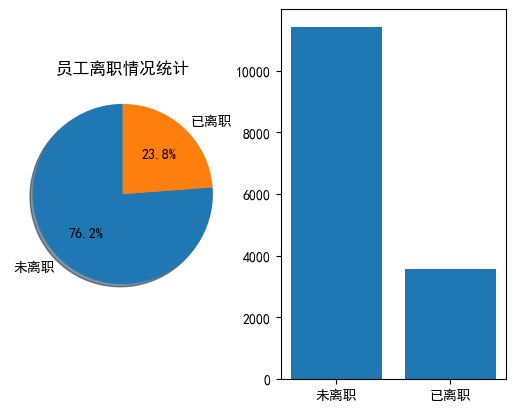

In [9]:
plt.subplot2grid((1, 2), (0, 0))
dimission_data = HR_comma_sep['是否离职'].value_counts()
plt.pie([dimission_data[0]/HR_comma_sep['是否离职'].count(), dimission_data[1]/HR_comma_sep['是否离职'].count()], labels=['未离职', '已离职'], autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('员工离职情况统计')

plt.subplot2grid((1, 2), (0, 1))
index = ['未离职', '已离职']
values = [dimission_data[0], dimission_data[1]]
plt.bar(index, values)
plt.show()


```可以看到,有23.8%的员工离职,76.2%的员工尚未离职。```

#### 员工工作部门与离职频率的可视化分析

Text(0, 0.5, '是否离职数量统计')

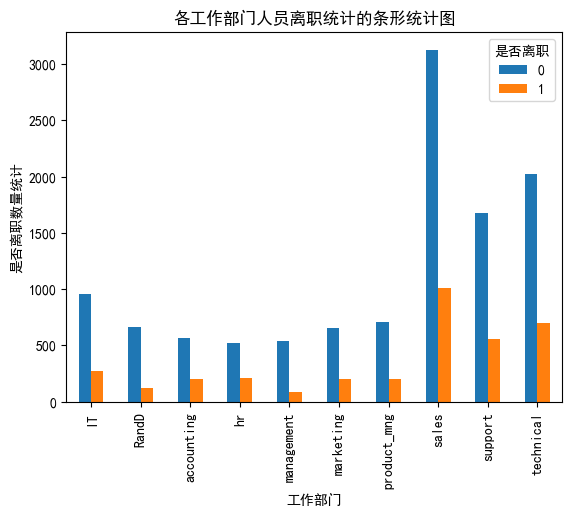

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
pd.crosstab(HR_comma_sep['工作部门'],HR_comma_sep['是否离职']).plot(kind='bar')
plt.title('各工作部门人员离职统计的条形统计图')
plt.xlabel('工作部门')
plt.ylabel('是否离职数量统计')

```很明显,员工流失的频率在很大程度上取决于他们工作的部门。因此,部门可以很好地预测结果变量。```

#### 不同部门的员工之间基于工作满意程度的流失比较

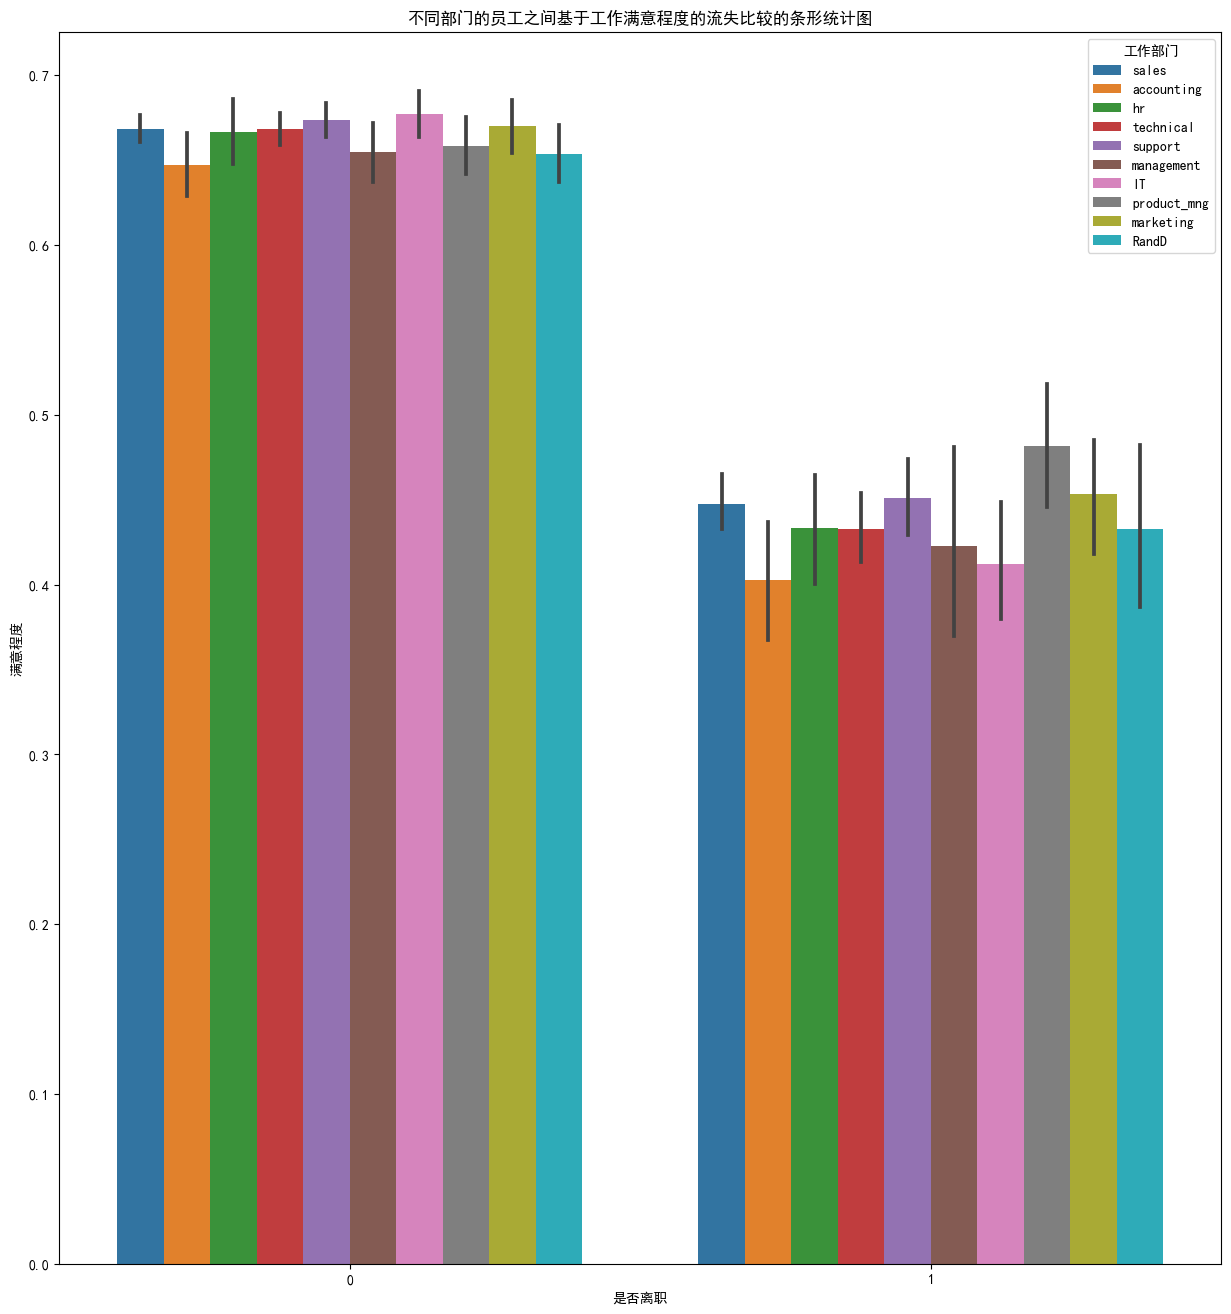

In [11]:
plt.figure(figsize = (15,16))
ax = sns.barplot(x="是否离职", y="满意程度", hue="工作部门", data=HR_comma_sep)
ax.set_title("不同部门的员工之间基于工作满意程度的流失比较的条形统计图")
plt.show()

```可以发现,未离职且在IT部门工作的员工满意度最高,已离职并在会计部门工作的员工满意度最低。```

#### 工资水平和离职频率可视化分析

Text(0, 0.5, '员工比例')

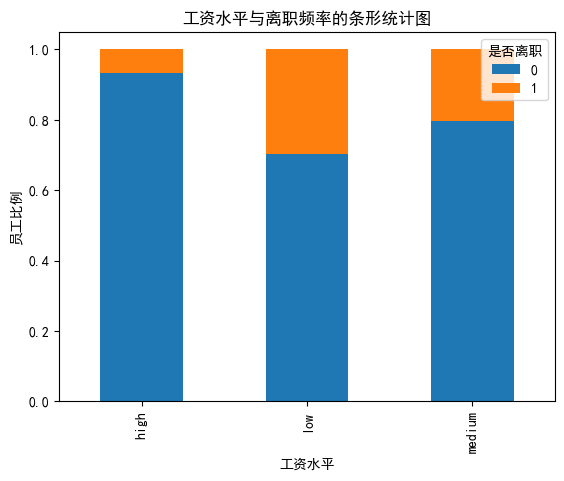

In [12]:
table=pd.crosstab(HR_comma_sep['工资水平'], HR_comma_sep['是否离职'])
table.div(table.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('工资水平与离职频率的条形统计图')
plt.xlabel('工资水平')
plt.ylabel('员工比例')

```员工离职的比例很大程度上取决于他们的薪资水平。因此工资水平可以很好地预测结果。```

#### 工龄与工资水平的可视化分析

In [13]:
Working_age_and_salary_level=pd.crosstab(HR_comma_sep["工资水平"],HR_comma_sep["工龄"])
Working_age_and_salary_level

工龄,2,3,4,5,6,7,8,10
工资水平,,,,,,,,
high,303,520,173,66,55,38,18,64
low,1527,3205,1300,799,333,36,60,56
medium,1414,2718,1084,608,330,114,84,94


<function matplotlib.pyplot.show(close=None, block=None)>

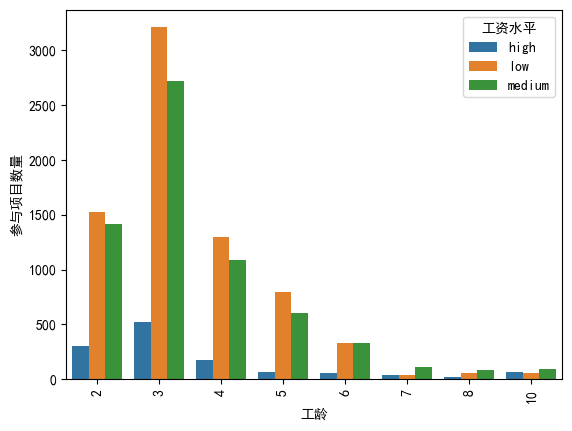

In [14]:
stacked = Working_age_and_salary_level.stack().reset_index().rename(columns={0:'参与项目数量'})
sns.barplot(x=stacked['工龄'], y=stacked['参与项目数量'], hue=stacked['工资水平'])
plt.xticks(rotation=90)
plt.show

```可以发现,与其他工作了4~10年的员工相比,工作3年且薪水最低的员工参与的项目数量最多```

#### 各个特征变量的平均值对员工是否离职的比较分析

In [15]:
HR_comma_sep.groupby('是否离职').mean()

,满意程度,绩效评估,参与项目数量,每月平均工作时长,工龄,是否有工伤,过去5年是否升职
是否离职,,,,,,,
0,0.666810,0.715473,3.786664,199.060203,3.380032,0.175009,0.026251
1,0.440098,0.718113,3.855503,207.419210,3.876505,0.047326,0.005321


```
经比较分析,可以发现未离职的员工的平均满意度高于离职的员工;
离职的员工的每月平均工作时间超过未离职的员工;
与未发生工伤的员工相比,发生工伤的员工离职的可能性较小;
在过去5年中升职的员工比在过去5年中没有升职的员工离职的概率要更小。
离职和未离职的员工在绩效评估和参与项目数量上差异不大。
```

### 相关性分析

,满意程度,绩效评估,参与项目数量,每月平均工作时长,工龄,是否有工伤,过去5年是否升职,是否离职
满意程度,1.000000,0.105021,-0.142970,-0.020048,-0.100866,0.058697,0.025605,-0.388375
绩效评估,0.105021,1.000000,0.349333,0.339742,0.131591,-0.007104,-0.008684,0.006567
参与项目数量,-0.142970,0.349333,1.000000,0.417211,0.196786,-0.004741,-0.006064,0.023787
每月平均工作时长,-0.020048,0.339742,0.417211,1.000000,0.127755,-0.010143,-0.003544,0.071287
工龄,-0.100866,0.131591,0.196786,0.127755,1.000000,0.002120,0.067433,0.144822
是否有工伤,0.058697,-0.007104,-0.004741,-0.010143,0.002120,1.000000,0.039245,-0.154622
过去5年是否升职,0.025605,-0.008684,-0.006064,-0.003544,0.067433,0.039245,1.000000,-0.061788
是否离职,-0.388375,0.006567,0.023787,0.071287,0.144822,-0.154622,-0.061788,1.000000


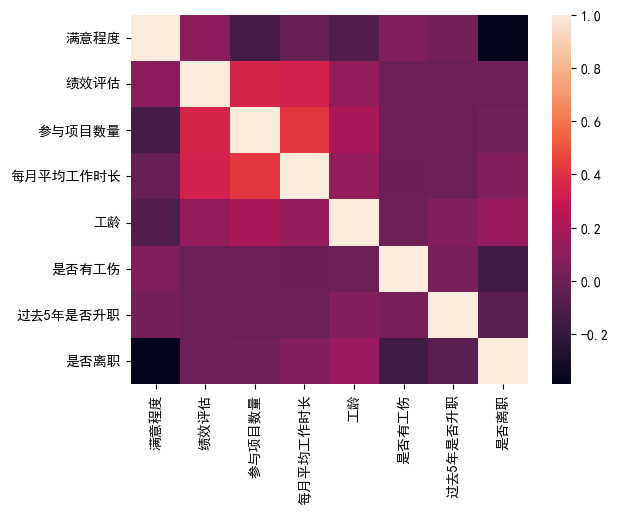

In [16]:
corr = HR_comma_sep.corr()  # 相关性矩阵
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
corr


## 建立决策树模型

In [17]:
HR_comma_sep = HR_comma_sep.sample(frac = 1) #抽取全部数据
HR_comma_sep.tail() # 对数据集进行矩阵形式的显示，默认显示为数据集的最后5行

,满意程度,绩效评估,参与项目数量,每月平均工作时长,工龄,是否有工伤,过去5年是否升职,工作部门,工资水平,是否离职
13123,0.52,0.57,3,270,3,0,0,RandD,low,0
3264,0.59,0.79,4,209,2,0,0,technical,medium,0
9845,0.69,0.94,5,259,2,0,0,IT,medium,0
10799,0.78,0.59,5,236,3,0,0,technical,high,0
2732,0.56,0.68,5,203,2,0,0,IT,low,0


In [18]:
cat_vars = ['工作部门', '工资水平']
for var in cat_vars:
    cat_list = 'var'+'_'+var
    cat_list = pd.get_dummies(HR_comma_sep[var], prefix=var)
    temp = HR_comma_sep.join(cat_list)
    HR_comma_sep = temp

In [19]:
# 删除工作部门和工资水平两个特征量
HR_comma_sep.drop(HR_comma_sep.columns[[7, 8]], axis=1, inplace=True)
HR_comma_sep.columns.values

array(['满意程度', '绩效评估', '参与项目数量', '每月平均工作时长', '工龄', '是否有工伤', '过去5年是否升职',
       '是否离职', '工作部门_IT', '工作部门_RandD', '工作部门_accounting', '工作部门_hr',
       '工作部门_management', '工作部门_marketing', '工作部门_product_mng',
       '工作部门_sales', '工作部门_support', '工作部门_technical', '工资水平_high',
       '工资水平_low', '工资水平_medium'], dtype=object)

In [20]:
cols = ['满意程度', '绩效评估', '参与项目数量', '每月平均工作时长', '工龄', 
        '是否有工伤', '过去5年是否升职','工作部门_IT', '工作部门_RandD', 
        '工作部门_accounting', '工作部门_hr','工作部门_management', 
        '工作部门_marketing', '工作部门_product_mng','工作部门_sales',
        '工作部门_support', '工作部门_technical', '工资水平_high',
        '工资水平_low', '工资水平_medium']
X = HR_comma_sep[cols]
y = HR_comma_sep['是否离职']

In [21]:
X_train,X_test, y_train, y_test = train_test_split(X,y , test_size = 0.2 ,random_state=0)  #划分数据集

In [22]:
print("训练集数据规模\n","X_train:",X_train.shape,"\n X_test:",X_test.shape)  
print("\n测试集数据规模\n","y_train:",y_test.shape,"\n y_test:",y_test.shape)  

训练集数据规模
 X_train: (11999, 20) 
 X_test: (3000, 20)

测试集数据规模
 y_train: (3000,) 
 y_test: (3000,)


In [23]:
clf = dt()           
clf.fit(X_train,y_train)

DecisionTreeClassifier()

In [24]:
out = clf.predict(X_test)
out

array([0, 0, 0, ..., 0, 1, 0], dtype=int64)

In [25]:
np.sum(out == y_test)/y_test.values.size*100

97.86666666666667

In [26]:
d=clf.predict(X_test)
pred_hr=pd.DataFrame(d)
pred_hr

,0
0,0
1,0
2,0
3,0
4,0
...,...
2995,0
2996,0
2997,0
2998,1


<AxesSubplot:>

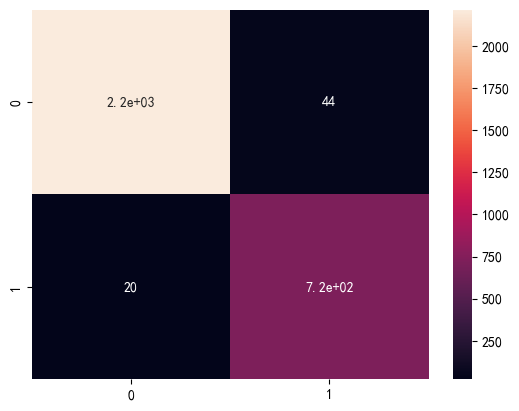

In [27]:
# 混淆矩阵
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, pred_hr)
cm
sns.heatmap(confusion_matrix(y_test,pred_hr),annot = True)

In [28]:
#决策树的混淆矩阵
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
cm = confusion_matrix(y_test, pred_hr)
print('TN – True Negative {}'.format(cm[0,0]))
print('FP – False Positive {}'.format(cm[0,1]))
print('FN – False Negative {}'.format(cm[1,0]))
print('TP – True Positive {}'.format(cm[1,1]))

TN – True Negative 2218
FP – False Positive 44
FN – False Negative 20
TP – True Positive 718


In [29]:
print('决策树分类报告: \n', classification_report(y_test, pred_hr, digits = 4))

决策树分类报告: 
               precision    recall  f1-score   support

           0     0.9911    0.9805    0.9858      2262
           1     0.9423    0.9729    0.9573       738

    accuracy                         0.9787      3000
   macro avg     0.9667    0.9767    0.9716      3000
weighted avg     0.9791    0.9787    0.9788      3000



In [30]:
auc = round(roc_auc_score(y_test, pred_hr)*100,2)
print('roc_auc_score of DT :' , auc)

roc_auc_score of DT : 97.67


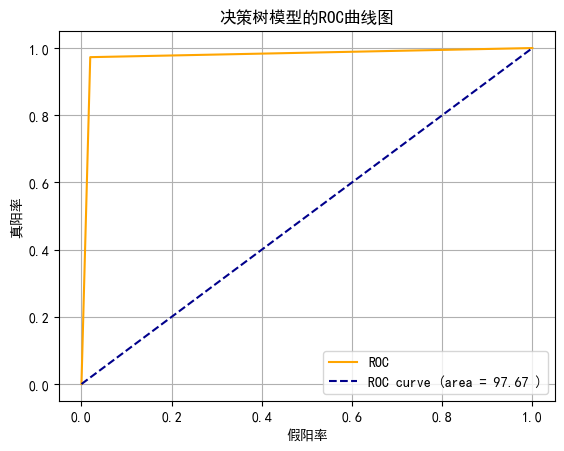

In [31]:
fpr, tpr, thresholds = roc_curve(y_test, pred_hr)
plt.plot(fpr, tpr, color = 'orange', label = 'ROC')
plt.plot([0,1],[0,1], color='darkblue' , linestyle='--' , label = 'ROC curve (area = %0.2f )' % auc)
plt.xlabel('假阳率')
plt.ylabel('真阳率')
plt.title('决策树模型的ROC曲线图')
plt.legend()
plt.grid()
plt.show()

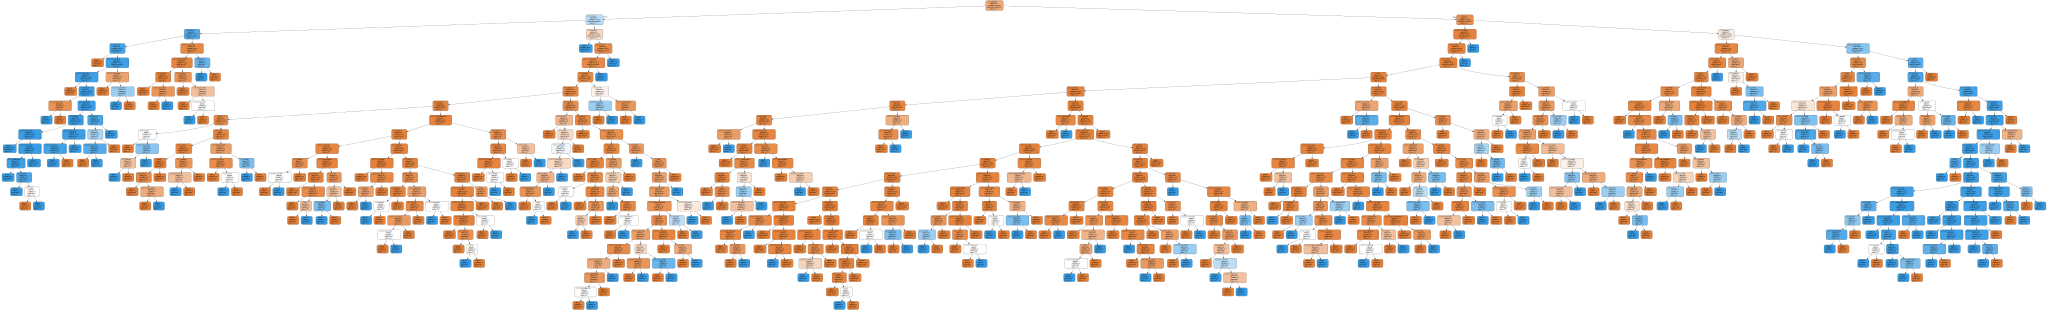

In [32]:
import graphviz
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

features_n = ['满意程度', '绩效评估', '参与项目数量', '每月平均工作时长', '工龄', '是否有工伤', '过去5年是否升职',
        '工作部门_IT', '工作部门_RandD', '工作部门_accounting', '工作部门_hr',
        '工作部门_management', '工作部门_marketing', '工作部门_product_mng',
        '工作部门_sales', '工作部门_support', '工作部门_technical', '工资水平_high',
        '工资水平_low', '工资水平_medium']
X_train_n = scaler.fit_transform(HR_comma_sep[features_n])
data = export_graphviz(DecisionTreeClassifier().fit(X, y), out_file=None, 
                       feature_names = features_n,
                       class_names = ['在职', '离职'], 
                       filled = True, rounded = True, special_characters = True)
graph = graphviz.Source(data)
graph

In [33]:
# 特征重要性评估
importances = clf.feature_importances_
importances_df = pd.DataFrame()
importances_df['特征变量'] = features_n
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征变量,特征重要性
0,满意程度,0.487516
1,绩效评估,0.148475
4,工龄,0.145212
2,参与项目数量,0.106169
3,每月平均工作时长,0.085905
16,工作部门_technical,0.005166
15,工作部门_support,0.004414
14,工作部门_sales,0.002517
19,工资水平_medium,0.002498
17,工资水平_high,0.002381


## 建立随机森林模型

In [34]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

In [35]:
print('随机森林模型准确率: {:.3f}'.format(accuracy_score(y_test, rf.predict(X_test))))

随机森林模型准确率: 0.991


In [36]:
from sklearn.metrics import classification_report
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99      2262
           1       0.99      0.97      0.98       738

    accuracy                           0.99      3000
   macro avg       0.99      0.98      0.99      3000
weighted avg       0.99      0.99      0.99      3000



In [37]:
a=rf.predict(X_test)
pred_hr_rf=pd.DataFrame(a)
pred_hr_rf

,0
0,0
1,0
2,0
3,0
4,0
...,...
2995,0
2996,0
2997,0
2998,1


<AxesSubplot:>

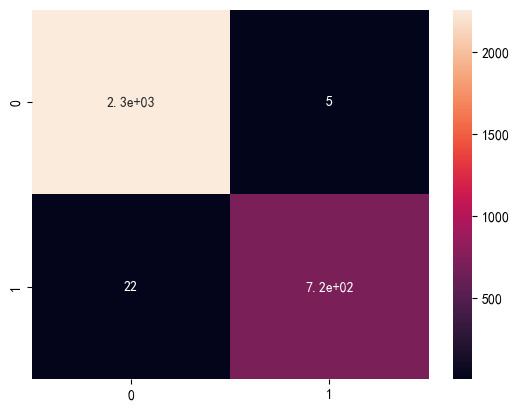

In [38]:
# 随机森林模型的混淆矩阵
from sklearn.metrics import classification_report
cm = confusion_matrix(y_test, pred_hr_rf)
cm
sns.heatmap(confusion_matrix(y_test,pred_hr_rf),annot = True)

In [39]:
#制作随机森林模型的混淆矩阵
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
cm = confusion_matrix(y_test, pred_hr_rf)
print('TN – True Negative {}'.format(cm[0,0]))
print('FP – False Positive {}'.format(cm[0,1]))
print('FN – False Negative {}'.format(cm[1,0]))
print('TP – True Positive {}'.format(cm[1,1]))

TN – True Negative 2257
FP – False Positive 5
FN – False Negative 22
TP – True Positive 716


In [40]:
print('随机森林模型分类报告: \n', classification_report(y_test, pred_hr_rf, digits = 4))

随机森林模型分类报告: 
               precision    recall  f1-score   support

           0     0.9903    0.9978    0.9941      2262
           1     0.9931    0.9702    0.9815       738

    accuracy                         0.9910      3000
   macro avg     0.9917    0.9840    0.9878      3000
weighted avg     0.9910    0.9910    0.9910      3000



In [41]:
auc = round(roc_auc_score(y_test, pred_hr_rf)*100,2)
print('roc_auc_score of RF :' , auc)

roc_auc_score of RF : 98.4


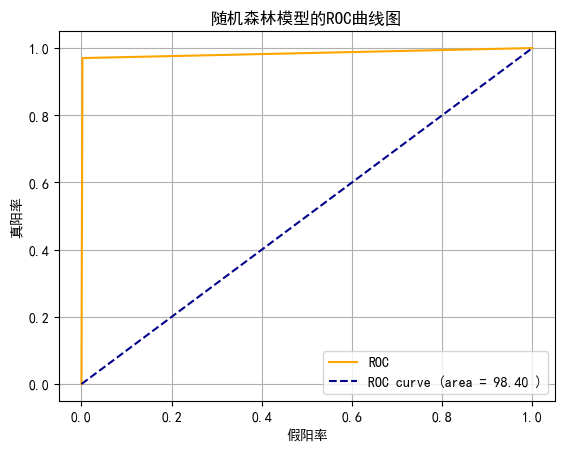

In [42]:
fpr, tpr, thresholds = roc_curve(y_test, pred_hr_rf)
plt.plot(fpr, tpr, color = 'orange', label = 'ROC')
plt.plot([0,1],[0,1], color='darkblue' , linestyle='--' , label = 'ROC curve (area = %0.2f )' % auc)
plt.xlabel('假阳率')
plt.ylabel('真阳率')
plt.title('随机森林模型的ROC曲线图')
plt.legend()
plt.grid()
plt.show()

In [43]:
# 特征重要性评估
importances = rf.feature_importances_
importances_df = pd.DataFrame()
importances_df['特征变量'] = features_n
importances_df['特征重要性'] = importances
importances_df.sort_values('特征重要性', ascending=False)

,特征变量,特征重要性
0,满意程度,0.299759
4,工龄,0.188278
2,参与项目数量,0.186822
3,每月平均工作时长,0.150684
1,绩效评估,0.127221
5,是否有工伤,0.009533
17,工资水平_high,0.006173
18,工资水平_low,0.006013
16,工作部门_technical,0.003724
19,工资水平_medium,0.003530
